# Energy Consumption Forecasting

### Libraries 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

### dataset load

In [13]:
file_path = "/kaggle/input/energy/Predicting Energy Consumption.xlsm"
df = pd.read_excel(file_path, engine="openpyxl")


In [14]:
# Rename columns
df = df.rename(columns={
    "Start time UTC": "start_time",
    "End time UTC": "end_time",
    "Electricity consumption (MWh)": "consumption"
})

In [15]:
# Convert datetime
df["start_time"] = pd.to_datetime(df["start_time"])
df["end_time"] = pd.to_datetime(df["end_time"])

In [16]:
# Sort by time
df = df.sort_values("start_time").reset_index(drop=True)

In [17]:
# Set start_time as index
df = df.set_index("start_time")

### missing data filling

In [18]:
df = df.asfreq("h")  # enforce hourly frequency

# Fill missing consumption using time interpolation
df["consumption"] = df["consumption"].interpolate(method="time")


### Sometimes the dataset has abnormally high/low values
### If we don’t handle them:
### the model can overfit those extreme points

In [19]:

low = df["consumption"].quantile(0.01)
high = df["consumption"].quantile(0.99)
df["consumption"] = df["consumption"].clip(low, high)

## capture daily/weekly/monthly patterns.

In [20]:
# Calendar features
df["hour"] = df.index.hour
df["day"] = df.index.day
df["month"] = df.index.month
df["weekday"] = df.index.weekday
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
df["dayofyear"] = df.index.dayofyear


## 23:00:00 can relate to 00:00:00

In [21]:
# Cyclical encoding
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)


## capture dependency on previous hour, previous day, and previous week.

In [39]:
# Lag features

df["lag_1"] = df["consumption"].shift(1)
df["lag_24"] = df["consumption"].shift(24)
df["lag_168"] = df["consumption"].shift(168)

## captures short-term trend and smooths noise.

In [23]:
# Rolling window features
df["roll_mean_3"] = df["consumption"].rolling(3).mean()
df["roll_mean_24"] = df["consumption"].rolling(24).mean()
df["roll_std_24"] = df["consumption"].rolling(24).std()

In [24]:
df = df.dropna()

## created some more features based on exisitng features

## splitting dependent and independent features

In [25]:
features = [
    "hour", "day", "month", "weekday", "is_weekend", "dayofyear",
    "hour_sin", "hour_cos", "month_sin", "month_cos",
    "lag_1", "lag_24", "lag_168",
    "roll_mean_3", "roll_mean_24", "roll_std_24"
]

X = df[features]
y = df["consumption"]

In [26]:
# split data into 80-20
split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

### Random Forest model

In [35]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=15
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

## two evalution metric for regression
##  **MAE**: average absolute prediction error.
## **RMSE**: penalizes large errors during peak demand.

In [36]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE  :", round(mae, 2))
print("RMSE :", round(rmse, 2))

MAE  : 62.85
RMSE : 88.52


## actual and predicate results for first 10 samples

In [37]:
pred_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
}, index=y_test.index)

print("\nSample Predictions:")
print(pred_df.head(10))


Sample Predictions:
                     Actual    Predicted
start_time                              
2020-10-24 00:00:00  8292.0  8372.430397
2020-10-24 01:00:00  8361.0  8381.233688
2020-10-24 02:00:00  8478.0  8396.035798
2020-10-24 03:00:00  8562.0  8552.805756
2020-10-24 04:00:00  8806.0  8724.926185
2020-10-24 05:00:00  9143.0  8962.946446
2020-10-24 06:00:00  9195.0  9188.803688
2020-10-24 07:00:00  9463.0  9364.258330
2020-10-24 08:00:00  9446.0  9484.905766
2020-10-24 09:00:00  9401.0  9504.231961


# Plot first 200 test hours for visualization

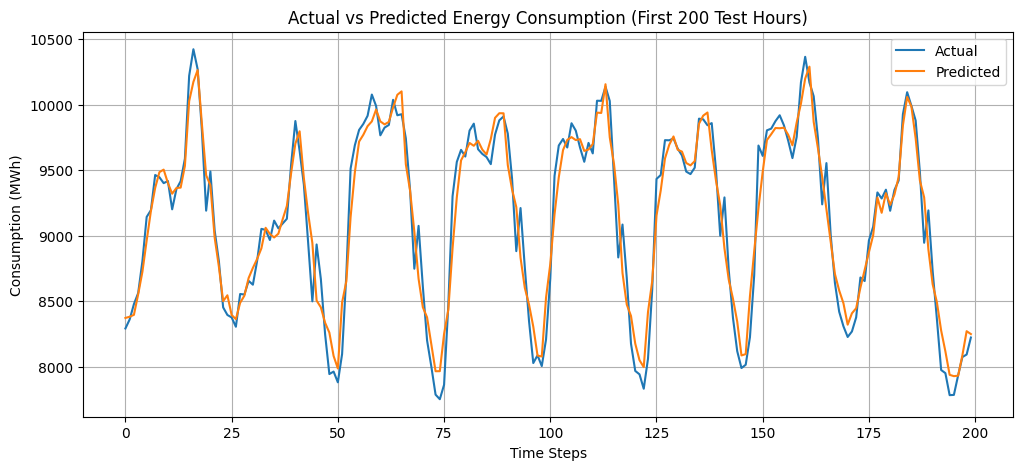

In [38]:
plt.figure(figsize=(12,5))
plt.plot(pred_df["Actual"].values[:200], label="Actual")
plt.plot(pred_df["Predicted"].values[:200], label="Predicted")
plt.title("Actual vs Predicted Energy Consumption (First 200 Test Hours)")
plt.xlabel("Time Steps")
plt.ylabel("Consumption (MWh)")
plt.legend()
plt.grid(True)
plt.show()